In [ ]:
import sys
# Import NDVM modules to load pickled data
# Action: Modify based on local filesystem
sys.path.append('../NDVM/ndvm/modules')
sys.path.append('../Dataset/NDVM/ndvm/')
import os
import pickle
import metric1, metric2, metric3
import json
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import matplotlib.cm as cm
import pandas as pd

In [ ]:
# Action: Modify based on local filesystem
REPORT_NAME = "../report-dataset-1745411944"

# General Report 

In [58]:
with open(REPORT_NAME+'.csv', 'r') as file:
    basic = json.load(file)
pprint(basic)

{'Analyzed Samples': {'Miner': 25000, 'Other': 25000},
 'Association': {'Association': 0.4087990963562529,
                 'Max Clf Score': 0.9918907993089827,
                 'P-value status': 'Good',
                 'P-value table': '           50        30        10        '
                                  '1 \n'
                                  'DT   0.009901  0.009901  0.009901  '
                                  '0.009901\n'
                                  'RF   0.009901  0.009901  0.009901  '
                                  '0.009901\n'
                                  'XGB  0.009901  0.009901  0.009901  0.009901',
                 'Raw AUC': "[0.39457438404409295, 'RF']",
                 'Raw Slope': "[0.9828927517010012, 'XGB']"},
 'Classes': 2,
 'Date': '04/23/25',
 'Duplicated Feature Vectors': 476109,
 'Feature List': {'DIR_1': '',
                  'DIR_10': '',
                  'DIR_11': '',
                  'DIR_12': '',
                  'DIR_13': '',
   

# Metric 1

In [59]:
with open(REPORT_NAME+"-metric1/metric1.obj", "rb") as f:
    metric1 = pickle.load(f)

In [60]:
metric1.ds_redundancy

0.9296875

In [61]:
data = metric1.redundancy_metadata

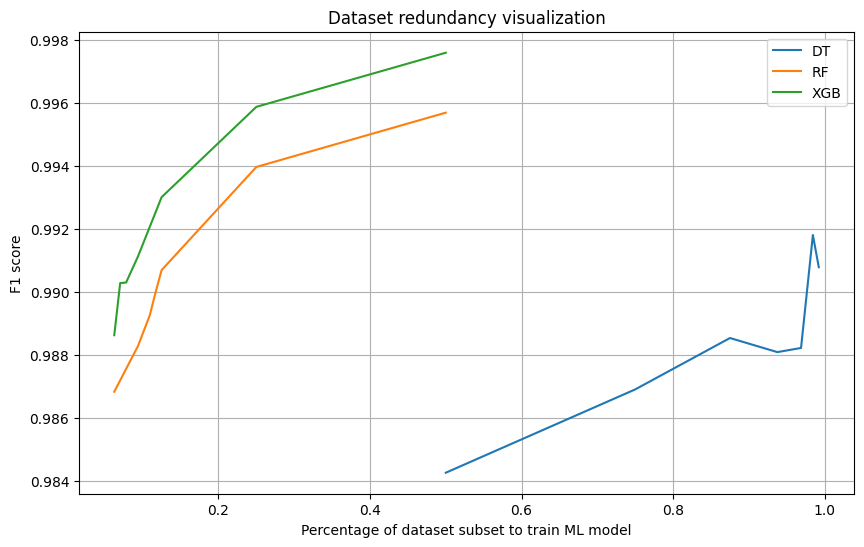

In [62]:
plt.figure(figsize=(10, 6))

for item in data:
    for name, values in item.items():
        x_values = sorted(values.keys())
        y_values = []
        for x in x_values:
            # Calculate the average of the last values (assuming each list has 5 values)
            avg_y = np.mean([v[0] for v in values[x]])
            y_values.append(avg_y)
        plt.plot(x_values, y_values, label=name)

plt.xlabel("Percentage of dataset subset to train ML model")
plt.ylabel("F1 score")
plt.title("Dataset redundancy visualization")
plt.legend()
plt.grid(True)
plt.show()

# Metric 2

In [ ]:
with open(REPORT_NAME+"-metric2/metric2.obj", "rb") as f:
    metric2 = pickle.load(f)

In [64]:
metric2.raw_slope

[0.9828927517010012, 'XGB']

In [48]:
metric2.print_results()

##### Results #####
P-value table
           50        30        10        1 
DT   0.009901  0.009901  0.009901  0.009901
RF   0.009901  0.009901  0.009901  0.009901
XGB  0.009901  0.009901  0.009901  0.009901
DT = 0.9742333633704704
RF = 0.9910941177104862
XGB = 0.9782506216165632
Max Slope
Slope: 0.9910941177104862 - RF
AUC: 0.3949280914287379 - XGB
Top AUC 0.39492809142873786 - Max F1: 0.9911177965509802 - Final Metric: 0.40613056166256056


In [49]:
colors = cm.rainbow(np.linspace(0, 1, metric2.a[1]))

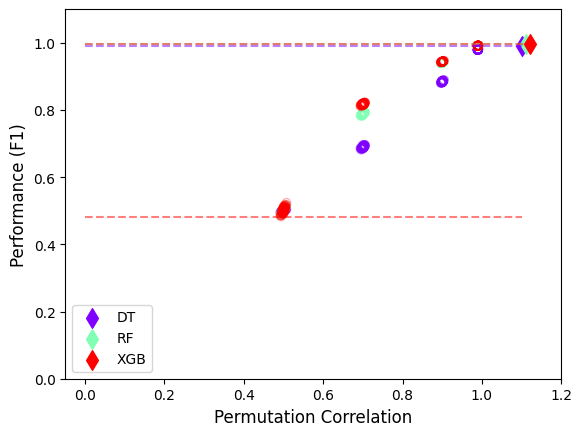

,50,30,10,1
DT,0.009901,0.009901,0.009901,0.009901
RF,0.009901,0.009901,0.009901,0.009901
XGB,0.009901,0.009901,0.009901,0.009901


In [50]:
pvalues = np.zeros((metric2.a[1],len(metric2.perc)))
colors = cm.rainbow(np.linspace(0, 1, metric2.a[1]))

# plot true values as diamonds
for i, c in zip(range(metric2.a[1]),colors):
    plt.scatter(1.1+i*0.01, metric2.ev.scores.mean(axis=2)[:, i, 0], s=100, color=c, marker='d')
    
plt.legend((metric2.clfs))

# plot lines for true values
for i, c in zip(range(metric2.a[1]),colors):
    plt.plot([0, 1.1+i*0.01], [metric2.ev.scores.mean(axis=2)[:, i, 0], metric2.ev.scores.mean(axis=2)[:, i, 0]], c=c, linestyle='dashed', alpha=0.5)

# plot permutations
colors = cm.rainbow(np.linspace(0, 1, metric2.a[1]))
for j in range(len(metric2.perc)):
    for i, c in zip(range(metric2.a[1]),colors):
        ind = np.where(metric2.perm[:,j,i]<metric2.ev.scores.mean(axis=2)[:, i, 0])
        plt.scatter((metric2.corr[ind,j]), metric2.perm[ind,j,i], color="none", edgecolor=c, alpha=0.3)
        
for j in range(len(metric2.perc)):
    for i, c in zip(range(metric2.a[1]),colors):
        ind = np.where(metric2.perm[:,j,i]>=metric2.ev.scores.mean(axis=2)[:, i, 0])
        plt.scatter((metric2.corr[ind,j]), metric2.perm[ind,j,i], color=c, edgecolor="black", alpha=1)
        pvalues[i,j] = ((len(ind[0])+1)*1.0)/(metric2.nperm+1);

plt.ylabel('Performance (F1)', size=12)
plt.xlabel('Permutation Correlation', size=12)       

plt.plot([0, 1.1], [metric2.perm.min(), metric2.perm.min()], color='red', linestyle='dashed', alpha=0.5)

plt.axis([-0.05, 1.2, 0, 1.1])

plt.show()

pv = pd.DataFrame(data=pvalues, index=metric2.clfs, columns=metric2.perc)

def significant(v):
    return "font-weight: bold; color: red" if v > 0.01 else None

pv.style.applymap(significant)

DT = 0.9742333633704704
RF = 0.9910941177104862
XGB = 0.9782506216165632
Slope: 0.9910941177104862 - RF
AUC: 0.3949280914287379 - XGB


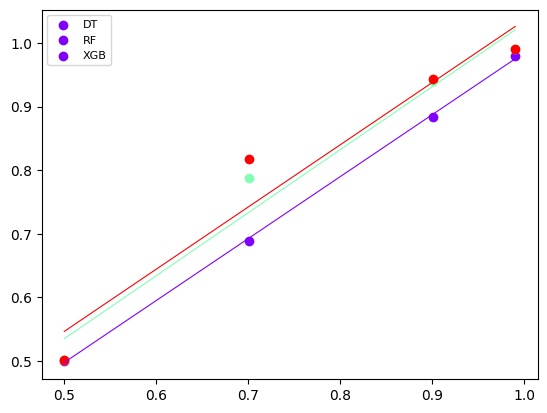

In [51]:
names = metric2.clfs
cor = []
per = []
slopes = []
auc_scores = []

for i, c in zip(range(metric2.a[1]),colors):
    for j in range(len(metric2.perc)):
        plt.scatter(np.mean(metric2.corr[:,j]), np.mean(metric2.perm[:,j,i]), color=c, alpha=1)
    
    cor = np.mean(metric2.corr[:,:], axis=0)
    per = np.mean(metric2.perm[:,:,i], axis=0)
    
    auc_score = auc(cor,per)
    slope, intercept = np.polyfit(cor, per, 1)
    plt.plot(cor, slope*cor + intercept, color=c, linewidth=0.8)
    print(names[i], '=', slope)
    slopes = np.append(slopes, slope)
    auc_scores = np.append(auc_scores, auc_score)

plt.legend(names, prop={'size': 8})

maxind = np.argmax(abs(slopes))
maxind_auc = np.argmax(abs(auc_scores))

print('Slope:', np.max(abs(slopes)), '-', names[maxind])
print('AUC:', np.max(abs(auc_scores)), '-', names[maxind_auc])

# Metric 3

In [52]:
with open(REPORT_NAME+"-metric3/metric3.obj", "rb") as f:
    metric3 = pickle.load(f)

In [53]:
# The base key
next(iter(basic["Similarity"]["detail"]))

'Other'

In [54]:
# All keys
basic["Similarity"]["detail"].keys()

dict_keys(['Other', 'Miner'])

In [55]:
# All metric 3 metadata
basic["Similarity"]["detail"]

{'Other': {'l1_loss': 0.030849959701299667, 'relative_loss': 1.0},
 'Miner': {'l1_loss': 0.045718979090452194,
  'relative_loss': 1.4819785676584243}}